In [2]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from math import e
from math import pi
from astropy.table import Column
from math import sqrt
import numpy as np
import emcee
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import math
import corner
from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb
import powerlaw
import random

In [34]:
AP_data_table_raw=Table.read("APData_csv.csv")

M=np.array(AP_data_table_raw['logMass-Best'])
Tau= np.array(AP_data_table_raw['logAge-Best'])

def M_lim(Tau):
    if 7.0 < Tau < 8.0 :
        return np.log10(740)
    if 8.0 < Tau < np.log10(300000000) : 
        return np.log10(1080)
    else:
        return 99
    
M_lim_a=np.zeros((len(M)))

for i in range(len(M)):
    M_lim_a[i]=M_lim(Tau[i])
    
M_lim_col= Column(M_lim_a, name='M_lim')
AP_data_table_raw.add_column(M_lim_col, index=10)

AP_data_table_raw

incomplete_ind_l=[]
for i in range(len(AP_data_table_raw)):
    if  AP_data_table_raw['M_lim'][i] > AP_data_table_raw['logMass-Best'][i] < 10:
        incomplete_ind_l.append(i)
        
incomplete_ind=np.array(incomplete_ind_l)

AP_data_table_raw.remove_rows([incomplete_ind])

AP_data_table_use=AP_data_table_raw

selecting=AP_data_table_use.group_by('logAge-Best')
np.where(selecting['logAge-Best']<8)

AP_data_table_lab8=selecting[:305]
AP_data_table_laa8=selecting[305:]

M_lab8=np.array(AP_data_table_lab8['logMass-Best'])
#M_lim_u=np.array(AP_data_table_use['M_lim'])
M_laa8=np.array(AP_data_table_laa8['logMass-Best'])

M_use= M_lab8, M_laa8

Mlim_lab8= 740
Mlim_laa8= 1080

M_lims= Mlim_lab8, Mlim_laa8

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/astropy/table/table.py:2226: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


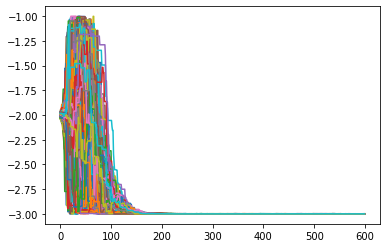

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


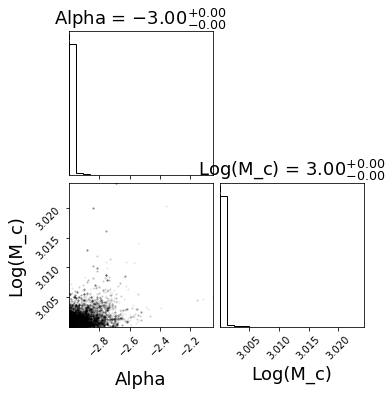

In [40]:
#Ob_Com needs to be in log space 
def lnobs_like(M, mlim):
    a_lim=5.0
    return -np.log(1+ exp(-a_lim*(M-mlim)))
        
def Shecter_Z(M, mlim, theta):
    alpha, M_c = theta
    lin_M_c= 10**M_c
    a_lim=5.0
    x = M/lin_M_c
    
    pobs=(1+ exp(-a_lim*(np.log10(M)-mlim))**(-1))
    
    return (x**alpha)*exp(-x)*pobs
        
    
def lnlike(theta, M_use, M_lims):
    alpha, M_c = theta
    M_lab8, M_laa8 = M_use
    Mlim_lab8, Mlim_laa8= M_lims
    lin_M_c= 10**M_c
    a_lim=5.0
    
    lin_Mu8= 10**M_lab8
    x_u8= lin_Mu8/lin_M_c
    ln_pobs_u8= lnobs_like(M_lab8, np.log10(Mlim_lab8))
    norm_u8, err = quad(Shecter_Z, Mlim_lab8, 10**8, args=(np.log10(Mlim_lab8), theta))
    lnlike_u8 = np.sum((-x_u8) + alpha*np.log(x_u8) + ln_pobs_u8 - np.log(norm_u8))
    
    lin_Ma8= 10**M_laa8
    x_a8= lin_Ma8/lin_M_c
    ln_pobs_a8= lnobs_like(M_laa8, np.log10(Mlim_laa8))
    norm_a8, err = quad(Shecter_Z, Mlim_laa8, 10**8, args=(np.log10(Mlim_laa8), theta))
    lnlike_a8 = np.sum((-x_a8) + alpha*np.log(x_a8) + ln_pobs_a8 - np.log(norm_a8))
    
    return lnlike_u8 + lnlike_a8
    
def lnprior(theta):
    alpha, M_c = theta
    if -3 <= alpha <= -1 and 3 <= M_c <= 8:
        return 0.0
    return -np.inf

def lnprob(theta, M_use, M_lims):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, M_use, M_lims)

starting_point=np.array([-1.99, 3.93])

ndim, nwalkers = 2, 500
nsteps= 600
burnin=100
pos = starting_point + 1e-2*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(M_use, M_lims))
sampler.run_mcmc(pos, nsteps)

#plot chain
plt.plot(np.transpose(sampler.chain[:,:,0]))
plt.show()
sampler.chain
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["Alpha", "Log(M_c)"], label_kwargs={"fontsize": 18},
                                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})

fig.show()